<a href="https://colab.research.google.com/github/freguti/Homework-ML/blob/Homework_3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [341]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging
import numpy as np
import pandas as pd
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
from copy import deepcopy

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 7 # 101 + 1: There is am extra Background class that should be removed 

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.005            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 10      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 8       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
LAMBDA = 0.1
LOG_FREQUENCY = 1

**Train without DANN**

In [0]:
import matplotlib.pyplot as plt
def train(model_base, train_dataloader, lrs = [LR], STEPs = [STEP_SIZE], Ns = [NUM_EPOCHS]):
  params = {'LR' : [], 'STEP_SIZE' : [], 'NUMBER_EPOCHS' : [], 'accuracy_cartoon' : [], 'accuracy_sketch' : [], 'loss' : [], 'model' : []}
  for lr,step_size,num_epoch in zip(lrs,STEPs,Ns):
    l_loss = []
    model = copy.deepcopy(model_base)
    print('lr {} step {} epochs {} '.format(lr,step_size,num_epoch))
    params['LR'].append(lr)
    params['STEP_SIZE'].append(step_size)
    params['NUMBER_EPOCHS'].append(num_epoch)
    # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

    # Choose parameters to optimize
    # To access a different set of parameters, you have to access submodules of AlexNet
    # (nn.Module objects, like AlexNet, implement the Composite Pattern)
    # e.g.: parameters of the fully connected layers: net.classifier.parameters()
    # e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
    parameters_to_optimize = model.parameters() # In this case we optimize over all the parameters of AlexNet

    # Define optimizer
    # An optimizer updates the weights based on loss
    # We use SGD with momentum
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    # Define scheduler
    # A scheduler dynamically changes learning rate
    # The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

    # By default, everything is loaded to cpu
    model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(num_epoch):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epoch, scheduler.get_lr()))

      # Iterate over the dataset
      n_loss = 0
      current_step = 0
      for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        model.train() # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients

        # Forward pass to the network
        outputs = model(images)

        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)

        # Compute gradients for each layer and update weights
        loss.backward()  # backward pass: computes gradients
        optimizer.step() # update weights based on accumulated gradients
        n_loss += loss.item()
        l_loss.append(loss.item())
        current_step += 1
      n_loss = n_loss/current_step
      print('Epoch {},Medium Loss {}'.format(epoch+1, n_loss))
      # Step the scheduler
      scheduler.step()
    plt.plot(l_loss,label='loss')
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.grid()
    plt.show() 
    params['loss'].append(n_loss)
    params['model'].append(copy.deepcopy(model))
  return params

In [0]:
def batch_it(dataloader_iterator,taget_dataloader):
  for i in range(len(taget_dataloader)):
    try:
      data = next(dataloader_iterator)
    except StopIteration:
      dataloader_iterator = iter(taget_dataloader)
      data = next(dataloader_iterator)
  return data[0],data[1] #data,target

**Train with DANN**

In [0]:
def DANN_train(model_base, train_dataloader,test_dataloader, lrs = [LR], STEPs = [STEP_SIZE], Ns = [NUM_EPOCHS], LAMBDAs = [LAMBDA]):
  params = {'LR' : [], 'STEP_SIZE' : [], 'NUMBER_EPOCHS' : [], 'LAMBDA' : [], 'accuracy_cartoon' : [], 'accuracy_sketch' : [], 'loss' : [],'domain_loss' : [],'test_domain_loss' : [], 'model' : []}
  for lr,step_size,num_epoch,v_lambda in zip(lrs,STEPs,Ns,LAMBDAs):
    l_loss = []
    d_loss = []
    td_loss = []
    model = copy.deepcopy(model_base)
    print('lr {} step {} epochs {} lambda {}'.format(lr,step_size,num_epoch,v_lambda))
    params['LR'].append(lr)
    params['STEP_SIZE'].append(step_size)
    params['NUMBER_EPOCHS'].append(num_epoch)
    params['LAMBDA'].append(v_lambda)
  # Define loss function
    criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

    # Choose parameters to optimize
    # To access a different set of parameters, you have to access submodules of AlexNet
    # (nn.Module objects, like AlexNet, implement the Composite Pattern)
    # e.g.: parameters of the fully connected layers: net.classifier.parameters()
    # e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
    parameters_to_optimize = model.parameters() # In this case we optimize over all the parameters of AlexNet

    # Define optimizer
    # An optimizer updates the weights based on loss
    # We use SGD with momentum
    optimizer = optim.SGD(parameters_to_optimize, lr=lr, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    # Define scheduler
    # A scheduler dynamically changes learning rate
    # The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=GAMMA)

    # By default, everything is loaded to cpu
    model = model.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0
    # Start iterating over the epochs
    for epoch in range(num_epoch):
      dataloader_iterator = iter(test_dataloader)
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, num_epoch, scheduler.get_lr()))
      n_loss = 0
      domainloss = 0
      t_domainloss = 0
      current_step = 0
      # Iterate over the dataset
      for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        model.train() # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad() # Zero-ing the gradients
        # Forward pass to the network
        outputs = model(images)
        # Compute loss based on output and ground truth
        loss = criterion(outputs, labels)
        # Compute gradients for each layer and update weights
        loss.backward()  # update gradients with loss.backward

        n_loss += loss.item()
        #training discriminator by forwarding source data
        outputs_discriminator = model.forward(images,v_lambda)
        target_s = torch.zeros(labels.size(0), dtype = torch.int64).to(DEVICE)
        loss_discriminator = criterion(outputs_discriminator,target_s)
        loss_discriminator.backward()

        domainloss += loss_discriminator.item()
        

        #load batch from test dataloader. For every train batch I have to take a test batch 
        images_test,label_test = dataloader_iterator.next()
        images_test = images_test.to(DEVICE)
        label_test = label_test.to(DEVICE)
        outputs_discriminator_test = model.forward(images_test,v_lambda)
        target_t = torch.ones(len(images_test), dtype = torch.int64).to(DEVICE)
        loss_discriminator_test = criterion(outputs_discriminator_test,target_t)
        loss_discriminator_test.backward()   
        print('Step {} loss {} domain loss {} test domain loss {} len test set {} alpha {}'.format(current_step,loss.item(),loss_discriminator.item(),loss_discriminator_test.item(),len(images_test),v_lambda))
        t_domainloss += loss_discriminator_test.item()
        l_loss.append(loss.item())
        d_loss.append(loss_discriminator.item())
        td_loss.append(loss_discriminator_test.item())
        current_step += 1
        optimizer.step() # update weights based on accumulated gradients
      n_loss = n_loss/current_step
      domainloss = domainloss/current_step
      t_domainloss = t_domainloss/current_step
      print('Epoch {},Medium Loss {}, Domain Loss (?) {}, Test domain loss {} '.format(epoch+1, n_loss, domainloss, t_domainloss))
      # Step the scheduler

      scheduler.step()
    plt.plot(l_loss,label='loss')
    plt.plot(d_loss,label='domain loss')
    plt.plot(td_loss,label='test domain loss')
    plt.ylabel('loss')
    plt.xlabel('step')
    plt.legend()
    plt.grid()
    plt.show()
    params['loss'].append(n_loss)
    params['domain_loss'].append(domainloss)
    params['test_domain_loss'].append(t_domainloss)
    params['model'].append(copy.deepcopy(model))
  return params

**Alex Net**

In [0]:
import torch
import torch.nn as nn
#from .utils import load_state_dict_from_url

try:
  from torch.hub import load_state_dict_from_url
except ImportError:
  from torch.utils.model_zoo import load_url as load_state_dict_from_url

__all__ = ['AlexNet', 'alexnet']
model_urls = { 'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', }

from torch.autograd import Function


class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        self.domainclassifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
        )

    def forward(self, x, alpha=None):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = x.view(x.size(0),-1)
        if alpha is not None:
          # gradient reversal layer (backward gradients will be reversed)
         reverse_feature = ReverseLayerF.apply(x, alpha)
         discriminator_output = self.domainclassifier(reverse_feature)
         return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
          # do something else
          class_outputs = self.classifier(x)
          return class_outputs
      

def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict, strict=False)
    return model

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Clone Github repository**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS



**Prepare Dataset**

In [350]:
train_dataset = torchvision.datasets.ImageFolder('./Homework3-PACS/PACS/photo',train_transform)
test_dataset = torchvision.datasets.ImageFolder('./Homework3-PACS/PACS/art_painting',train_transform)

#1/5 in test and 4/5 in train
#train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
#test_indexes = [idx for idx in range(len(test_dataset)) if not idx % 5]

#train_dataset = Subset(train_dataset, train_indexes)
#test_dataset = Subset(test_dataset, test_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Train Dataset: 1670
Test Dataset: 2048


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet(pretrained = True) # Loading AlexNet model
#copia dei pesi
net.classifier[6] = nn.Linear(4096, 7)
weight1=deepcopy(net.classifier[1].weight.data)
bias1=deepcopy(net.classifier[1].bias.data)
weight4=deepcopy(net.classifier[4].weight.data)
bias4=deepcopy(net.classifier[4].bias.data)
net.domainclassifier[1].weight.data=weight1
net.domainclassifier[1].bias.data=bias1
net.domainclassifier[4].weight.data=weight4
net.domainclassifier[4].bias.data=bias4
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
#criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
#parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
#optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

lr 0.005 step 8 epochs 10 
Starting epoch 1/10, LR = [0.005]
Epoch 1,Medium Loss 0.5349219945760874
Starting epoch 2/10, LR = [0.005]
Epoch 2,Medium Loss 0.11844177028307548
Starting epoch 3/10, LR = [0.005]
Epoch 3,Medium Loss 0.04706714202005129
Starting epoch 4/10, LR = [0.005]
Epoch 4,Medium Loss 0.03320274215478163
Starting epoch 5/10, LR = [0.005]
Epoch 5,Medium Loss 0.016883801095760785
Starting epoch 6/10, LR = [0.005]
Epoch 6,Medium Loss 0.009750601190787096
Starting epoch 7/10, LR = [0.005]
Epoch 7,Medium Loss 0.011857392409673104
Starting epoch 8/10, LR = [0.005]
Epoch 8,Medium Loss 0.00892814678641466
Starting epoch 9/10, LR = [0.0005]
Epoch 9,Medium Loss 0.0034602672721330938
Starting epoch 10/10, LR = [0.0005]
Epoch 10,Medium Loss 0.004530959977553441


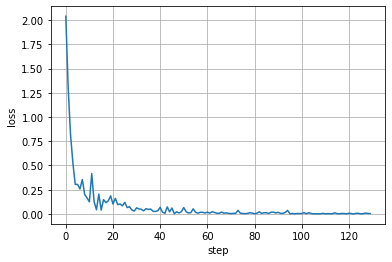

In [354]:
params = train(net,train_dataloader)

**Test**

In [355]:
net = copy.deepcopy(params['model'][0])
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images,labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:04<00:00,  5.47it/s]

Test Accuracy: 0.51904296875


lr 0.005 step 8 epochs 10 lambda 0.1
Starting epoch 1/10, LR = [0.005]
Step 0 loss 2.0230767726898193 domain loss 1.0853285789489746 test domain loss 0.8905986547470093 len test set 128 alpha 0.1
Step 1 loss 1.1095243692398071 domain loss 0.37176579236984253 test domain loss 0.15248113870620728 len test set 128 alpha 0.1
Step 2 loss 0.8025412559509277 domain loss 0.3601975440979004 test domain loss 0.26604902744293213 len test set 128 alpha 0.1
Step 3 loss 0.5292766094207764 domain loss 0.17706598341464996 test domain loss 0.18966439366340637 len test set 128 alpha 0.1
Step 4 loss 0.40661218762397766 domain loss 0.150106281042099 test domain loss 0.5022274255752563 len test set 128 alpha 0.1
Step 5 loss 0.2453438639640808 domain loss 0.6443755030632019 test domain loss 0.2514171302318573 len test set 128 alpha 0.1
Step 6 loss 0.17950350046157837 domain loss 0.47164472937583923 test domain loss 0.23105865716934204 len test set 128 alpha 0.1
Step 7 loss 0.19543713331222534 domain loss 0.

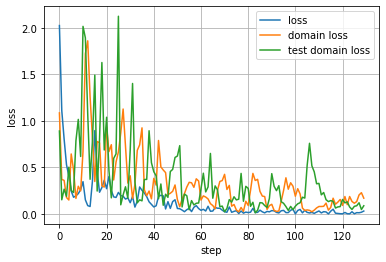

{'LR': [0.005], 'STEP_SIZE': [8], 'NUMBER_EPOCHS': [10], 'LAMBDA': [0.1], 'accuracy_cartoon': [], 'accuracy_sketch': [], 'loss': [0.011047833240949191], 'domain_loss': [0.14926538960291788], 'test_domain_loss': [0.09029783824315438], 'model': [AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_s

In [356]:
net = alexnet(pretrained = True) # Loading AlexNet model
#copia dei pesi
net.classifier[6] = nn.Linear(4096, 7)
weight1=deepcopy(net.classifier[1].weight.data)
bias1=deepcopy(net.classifier[1].bias.data)
weight4=deepcopy(net.classifier[4].weight.data)
bias4=deepcopy(net.classifier[4].bias.data)
net.domainclassifier[1].weight.data=weight1
net.domainclassifier[1].bias.data=bias1
net.domainclassifier[4].weight.data=weight4
net.domainclassifier[4].bias.data=bias4
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

params = DANN_train(net, train_dataloader,test_dataloader)
print(params)

In [357]:
net = copy.deepcopy(params['model'][0])
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 16/16 [00:03<00:00,  5.46it/s]

Test Accuracy: 0.53515625


**CROSS DOMAIN VALIDATION (GRID SEARCH)**

In [361]:
cartoon_dataset = torchvision.datasets.ImageFolder('./Homework3-PACS/PACS/cartoon',train_transform)
sketch_dataset = torchvision.datasets.ImageFolder('./Homework3-PACS/PACS/sketch',train_transform)

cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Check dataset sizes
print('Train Dataset: {}'.format(len(cartoon_dataset)))
print('Test Dataset: {}'.format(len(sketch_dataset)))

Train Dataset: 2344
Test Dataset: 3929


lr 0.001 step 6 epochs 10 
Starting epoch 1/10, LR = [0.001]
Epoch 1,Medium Loss 0.9522642768346347
Starting epoch 2/10, LR = [0.001]
Epoch 2,Medium Loss 0.1789948229606335
Starting epoch 3/10, LR = [0.001]
Epoch 3,Medium Loss 0.1153240312750523
Starting epoch 4/10, LR = [0.001]
Epoch 4,Medium Loss 0.08932366938545154
Starting epoch 5/10, LR = [0.001]
Epoch 5,Medium Loss 0.06010916427924083
Starting epoch 6/10, LR = [0.001]
Epoch 6,Medium Loss 0.05111426616517397
Starting epoch 7/10, LR = [0.0001]
Epoch 7,Medium Loss 0.04920659887676056
Starting epoch 8/10, LR = [0.0001]
Epoch 8,Medium Loss 0.035020895732136875
Starting epoch 9/10, LR = [0.0001]
Epoch 9,Medium Loss 0.038998702684274085
Starting epoch 10/10, LR = [0.0001]
Epoch 10,Medium Loss 0.03129887093718235


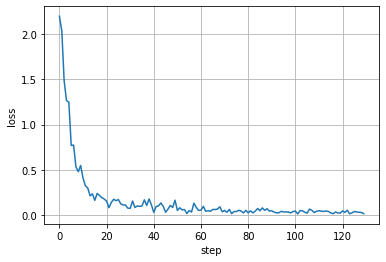

lr 0.01 step 10 epochs 15 
Starting epoch 1/15, LR = [0.01]
Epoch 1,Medium Loss 0.4782694818881842
Starting epoch 2/15, LR = [0.01]
Epoch 2,Medium Loss 0.13710982352495193
Starting epoch 3/15, LR = [0.01]
Epoch 3,Medium Loss 0.0811662138081514
Starting epoch 4/15, LR = [0.01]
Epoch 4,Medium Loss 0.06759239460986394
Starting epoch 5/15, LR = [0.01]
Epoch 5,Medium Loss 0.031054175817049466
Starting epoch 6/15, LR = [0.01]
Epoch 6,Medium Loss 0.02630692347884178
Starting epoch 7/15, LR = [0.01]
Epoch 7,Medium Loss 0.016330727017842807
Starting epoch 8/15, LR = [0.01]
Epoch 8,Medium Loss 0.01116402132006792
Starting epoch 9/15, LR = [0.01]
Epoch 9,Medium Loss 0.017806907542623006
Starting epoch 10/15, LR = [0.01]
Epoch 10,Medium Loss 0.01161283627152443
Starting epoch 11/15, LR = [0.001]
Epoch 11,Medium Loss 0.005758871539280965
Starting epoch 12/15, LR = [0.001]
Epoch 12,Medium Loss 0.0025671104399057534
Starting epoch 13/15, LR = [0.001]
Epoch 13,Medium Loss 0.002478775496666248
Starting

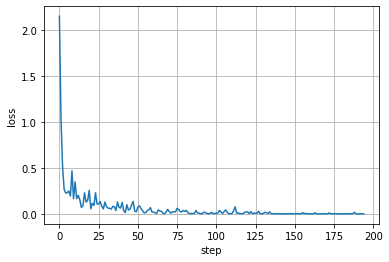

lr 0.05 step 15 epochs 20 
Starting epoch 1/20, LR = [0.05]
Epoch 1,Medium Loss nan
Starting epoch 2/20, LR = [0.05]
Epoch 2,Medium Loss nan
Starting epoch 3/20, LR = [0.05]
Epoch 3,Medium Loss nan
Starting epoch 4/20, LR = [0.05]
Epoch 4,Medium Loss nan
Starting epoch 5/20, LR = [0.05]
Epoch 5,Medium Loss nan
Starting epoch 6/20, LR = [0.05]
Epoch 6,Medium Loss nan
Starting epoch 7/20, LR = [0.05]
Epoch 7,Medium Loss nan
Starting epoch 8/20, LR = [0.05]
Epoch 8,Medium Loss nan
Starting epoch 9/20, LR = [0.05]
Epoch 9,Medium Loss nan
Starting epoch 10/20, LR = [0.05]
Epoch 10,Medium Loss nan
Starting epoch 11/20, LR = [0.05]
Epoch 11,Medium Loss nan
Starting epoch 12/20, LR = [0.05]
Epoch 12,Medium Loss nan
Starting epoch 13/20, LR = [0.05]
Epoch 13,Medium Loss nan
Starting epoch 14/20, LR = [0.05]
Epoch 14,Medium Loss nan
Starting epoch 15/20, LR = [0.05]
Epoch 15,Medium Loss nan
Starting epoch 16/20, LR = [0.005000000000000001]
Epoch 16,Medium Loss nan
Starting epoch 17/20, LR = [0.0

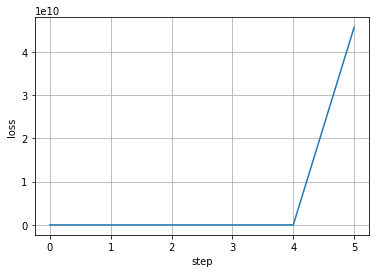

lr 0.005 step 8 epochs 10 
Starting epoch 1/10, LR = [0.005]
Epoch 1,Medium Loss 0.5419208877361738
Starting epoch 2/10, LR = [0.005]
Epoch 2,Medium Loss 0.1261170578117554
Starting epoch 3/10, LR = [0.005]
Epoch 3,Medium Loss 0.06943297730042385
Starting epoch 4/10, LR = [0.005]
Epoch 4,Medium Loss 0.03345642740336748
Starting epoch 5/10, LR = [0.005]
Epoch 5,Medium Loss 0.018335961665098485
Starting epoch 6/10, LR = [0.005]
Epoch 6,Medium Loss 0.01809128889670739
Starting epoch 7/10, LR = [0.005]
Epoch 7,Medium Loss 0.009471490692633849
Starting epoch 8/10, LR = [0.005]
Epoch 8,Medium Loss 0.009356092804899583
Starting epoch 9/10, LR = [0.0005]
Epoch 9,Medium Loss 0.0033530604380827686
Starting epoch 10/10, LR = [0.0005]
Epoch 10,Medium Loss 0.002612579040802442


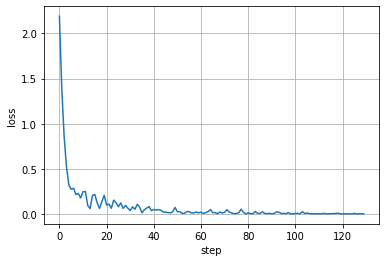

{'LR': [0.001, 0.01, 0.05, 0.005], 'STEP_SIZE': [6, 10, 15, 8], 'NUMBER_EPOCHS': [10, 15, 20, 10], 'accuracy_cartoon': [], 'accuracy_sketch': [], 'loss': [0.03129887093718235, 0.002462866214605478, nan, 0.002612579040802442], 'model': [AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, s

In [365]:
#cross domain validation
lrs =[0.001,0.01,0.05,0.005]
STEPs = [6,10,15,8] 
Ns =[10, 15, 20, 10]
LAMBDAs =[0.05,0.1,0.2, 0.1]

net = alexnet(pretrained = True) # Loading AlexNet model
#copia dei pesi
net.classifier[6] = nn.Linear(4096, 7)
weight1=deepcopy(net.classifier[1].weight.data)
bias1=deepcopy(net.classifier[1].bias.data)
weight4=deepcopy(net.classifier[4].weight.data)
bias4=deepcopy(net.classifier[4].bias.data)
net.domainclassifier[1].weight.data=weight1
net.domainclassifier[1].bias.data=bias1
net.domainclassifier[4].weight.data=weight4
net.domainclassifier[4].bias.data=bias4
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

params = train(net, train_dataloader,lrs,STEPs,Ns) #train su dataset photo

print(params)

In [366]:
for i in [0,1,2,3]:
  net = copy.deepcopy(params['model'][i])
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  #test on catoon
  running_corrects = 0
  for images, labels in tqdm(cartoon_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  params['accuracy_cartoon'].append(running_corrects / float(len(cartoon_dataset)))
  #test on sketch
  running_corrects = 0
  for images, labels in tqdm(sketch_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  params['accuracy_sketch'].append(running_corrects / float(len(sketch_dataset)))

100%|██████████| 31/31 [00:07<00:00,  6.36it/s]


In [367]:
max = 0
best_model = {'accuracy':0}
for lr,step,epoch,acc_cart,acc_sk,model in zip(params['LR'],params['STEP_SIZE'],params['NUMBER_EPOCHS'],params['accuracy_cartoon'], params['accuracy_sketch'],params['model']):
  medium_accuracy = (acc_cart + acc_sk) / 2
  if(medium_accuracy > max):
    best_model['model'] = copy.deepcopy(model)
    best_model['LR'] = lr
    best_model['STEP_SIZE'] = step
    best_model['NUMBER_EPOCHS'] = epoch
    best_model['accuracy'] = medium_accuracy
    max = medium_accuracy
    print('lr {} step {} epochs {} accuracy_cartoon {} accuracy_sketch {} -> medium accuracy {}'.format(lr,step,epoch,acc_cart,acc_sk, max))


lr 0.001 step 6 epochs 10 accuracy_cartoon 0.2098976109215017 accuracy_sketch 0.2237210486128786 -> medium accuracy 0.21680932976719014
lr 0.01 step 10 epochs 15 accuracy_cartoon 0.2935153583617747 accuracy_sketch 0.2746245864087554 -> medium accuracy 0.2840699723852651
lr 0.005 step 8 epochs 10 accuracy_cartoon 0.27517064846416384 accuracy_sketch 0.31051158055484857 -> medium accuracy 0.29284111450950623


In [0]:
net = copy.deepcopy(best_model['model']) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode
#test on catoon
running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))
print('\naccuracy on art dataset {}'.format(accuracy))

In [0]:
cartoon_dataset = Caltech(train_transform,sets = [1])
sketch_dataset = Caltech(eval_transform,sets = [3])
train_dataset = Caltech(train_transform,sets = [2])
test_dataset = Caltech(eval_transform,sets = [0])

cartoon_dataloader = DataLoader(cartoon_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
sketch_dataloader = DataLoader(sketch_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last = True)

**4c - 4d**

In [0]:
#cross domain validation
lrs =[0.001,0.01,0.05]
STEPs = [6,10,15] 
Ns =[10, 15, 20]
LAMBDAs =[0.05,0.1,0.2]

net = alexnet(pretrained = True) # Loading AlexNet model
#copia dei pesi
net.classifier[6] = nn.Linear(4096, 7)
weight1=deepcopy(net.classifier[1].weight.data)
bias1=deepcopy(net.classifier[1].bias.data)
weight4=deepcopy(net.classifier[4].weight.data)
bias4=deepcopy(net.classifier[4].bias.data)
net.domainclassifier[1].weight.data=weight1
net.domainclassifier[1].bias.data=bias1
net.domainclassifier[4].weight.data=weight4
net.domainclassifier[4].bias.data=bias4
# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is mandatory to study torchvision.models.alexnet source code

params_sk = DANN_train(net, train_dataloader,sketch_dataloader,lrs,STEPs,Ns,LAMBDAs) #train su dataset photo
params_ca = DANN_train(net, train_dataloader,cartoon_dataloader,lrs,STEPs,Ns,LAMBDAs) #train su dataset photo


print(params_sk)
print(params_ca)

In [0]:
for net in params['model']:
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  #test on catoon
  running_corrects = 0
  for images, labels in tqdm(cartoon_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  params['accuracy_cartoon'].append(running_corrects / float(len(cartoon_dataset)))
  #test on sketch
  running_corrects = 0
  for images, labels in tqdm(sketch_dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  params['accuracy_sketch'].append(running_corrects / float(len(sketch_dataset)))

In [0]:
max = 0
best_model = {'accuracy':0}
for lr,step,epoch,acc_cart,acc_sk,model,loss,dloss,tdloss in zip(params['LR'],params['STEP_SIZE'],params['NUMBER_EPOCHS'],params['accuracy_cartoon'], params['accuracy_sketch'],params['model'],params['loss'], params['domain_loss'], params['test_domain_loss']):
  medium_accuracy = (acc_cart + acc_sk) / 2
  if(medium_accuracy > max):
    best_DANN_model['model'] = copy.deepcopy(model)
    best_DANN_model['LR'] = lr
    best_DANN_model['STEP_SIZE'] = step
    best_DANN_model['NUMBER_EPOCHS'] = epoch
    best_DANN_model['accuracy'] = medium_accuracy
    best_DANN_model['loss'] = loss
    best_DANN_model['DomainLoss'] = dloss
    best_DANN_model['TestDomainLoss'] = tdloss
    max = medium_accuracy
    print('lr {} step {} epochs {} accuracy_cartoon {} accuracy_sketch {} -> medium accuracy {}'.format(lr,step,epoch,acc_cart,acc_sk, max))
    print('loss {} domain loss {} test domain loss {}'.format(loss,dloss,tdloss))